In [1]:
import pandas as pd 
import torch 
import os 
from sklearn.metrics import roc_auc_score
import numpy as np
from matplotlib_venn import venn3, venn2, venn3_circles
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn2, venn3_circles
from matplotlib.patches import Patch
from random import shuffle
from scipy.stats import percentileofscore
import statsmodels.api as sm
import statsmodels.formula.api as smf
import networkx as nx
from itertools import combinations

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor


import sys 
sys.path.append('../')
from src.proc.load_mut import * 
from src.proc.load_cnv import * 



In [2]:
data = torch.load(f'../output/exp1/proc/Data.pt')

cellspace = list(data.cellspace)
drugspace = [x.split('__')[1] for x in data.node_names if 'DRUG__' in x]

cellinfo = pd.read_csv('../../data/cellinfo_beta.txt', sep='\t')[lambda x: x.cell_iname.isin(cellspace)]

druginfo = pd.read_csv('../../data/compoundinfo_beta.txt', sep='\t')
drugindi = pd.read_csv('../../data/repurposing_drugs_20180907.txt', sep='\t', encoding = "ISO-8859-1", skiprows=9)[['pert_iname', 'disease_area', 'indication', 'clinical_phase']]
druginfo = druginfo.merge(drugindi, left_on='cmap_name', right_on='pert_iname', how='left')[lambda x: x.pert_id.isin(drugspace)]
druginfo.head()

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases,pert_iname,disease_area,indication,clinical_phase
410,BRD-K42805893,AZD-9291,NaN,NaN,COc1cc(N(C)CCN(C)C)c(NC(=O)C=C)cc1Nc1nccc(n1)-...,DUYJMQONPNNFPI-UHFFFAOYSA-N,osimertinib,NaN,NaN,NaN,NaN
508,BRD-K62391742,GDC-0199,NaN,NaN,CC1(C)CCC(CN2CCN(CC2)c2ccc(C(=O)NS(=O)(=O)c3cc...,LQBVNQSMGBZMKD-UHFFFAOYSA-N,venetoclax,NaN,NaN,NaN,NaN
605,BRD-K43002773,GDC-0068,AKT3,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib,GDC-0068,NaN,NaN,Phase 2
606,BRD-K43002773,GDC-0068,AKT1,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib,GDC-0068,NaN,NaN,Phase 2
607,BRD-K43002773,GDC-0068,AKT2,Akt inhibitor,C[C@@H]1C[C@H](C2=C1C(=NC=N2)N3CCN(CC3)C(=O)[C...,GRZXWCHAXNAUHY-NSISKUIASA-N,ipatasertib,GDC-0068,NaN,NaN,Phase 2


In [3]:
cell_diseases = cellinfo.groupby(['primary_disease', 'subtype']).count()[['cell_iname']].sort_values('cell_iname', ascending=False).reset_index()

# First, Generate Disease Specific Prioritization Goals

This will be used to evaluate the rationality of our priortization results using the CLUE repurposing hub disease indications. 

In [4]:
goal_metadata = pd.DataFrame({'goal_name':                  ['melanoma-NSCLC',                      'melanoma-breast',      'NSCLC-AML',                             'breast-AML',                          'breast-NSCLC',                          'breast-prostate',         'NSCLC-prostate',                       'breast-kidney',                    'NSCLC-kidney',                             'melanoma-kidney'],
                              'target_primary_disease':     ['skin cancer',                         'skin cancer',          'lung cancer',                           'breast cancer',                       'breast cancer',                         'breast cancer',           'lung cancer',                          'breast cancer',                    'lung cancer',                              'skin cancer'], 
                              'target_subtype':             ['melanoma',                            'melanoma',             'non small cell lung carcinoma',          None,                                  None,                                    None,                     'non small cell lung carcinoma',         None,                              'non small cell lung carcinoma',            'melanoma'],                   
                              'background_primary_disease': ['lung cancer',                         'breast cancer',        'leukemia',                              'leukemia',                            'lung cancer',                           'prostate cancer',         'prostate cancer',                      'kidney cancer',                    'kidney cancer',                            'kidney cancer'], 
                              'background_subtype':         ['non small cell lung carcinoma',        None,                  'acute myelogenous leukemia (aml)',      'acute myelogenous leukemia (aml)',    'non small cell lung carcinoma',          None,                      None,                                   None,                               None,                                       None],
                              'target_indication':          ['melanoma',                            'melanoma',             'non-small cell lung cancer (NSCLC)',    'breast cancer',                       'breast cancer',                         'breast cancer',           'non-small cell lung cancer (NSCLC)',   'breast cancer',                    'non-small cell lung cancer (NSCLC)',       'melanoma'],
                              'background_indication':      ['non-small cell lung cancer (NSCLC)',  'breast cancer',        'acute myeloid leukemia (AML)',          'acute myeloid leukemia (AML)',        'non-small cell lung cancer (NSCLC)',    'prostate cancer',         'prostate cancer',                      'renal cell carcinoma (RCC)',       'renal cell carcinoma (RCC)',               'renal cell carcinoma (RCC)']})

goal_metadata

,goal_name,target_primary_disease,target_subtype,background_primary_disease,background_subtype,target_indication,background_indication
0,melanoma-NSCLC,skin cancer,melanoma,lung cancer,non small cell lung carcinoma,melanoma,non-small cell lung cancer (NSCLC)
1,melanoma-breast,skin cancer,melanoma,breast cancer,None,melanoma,breast cancer
2,NSCLC-AML,lung cancer,non small cell lung carcinoma,leukemia,acute myelogenous leukemia (aml),non-small cell lung cancer (NSCLC),acute myeloid leukemia (AML)
3,breast-AML,breast cancer,None,leukemia,acute myelogenous leukemia (aml),breast cancer,acute myeloid leukemia (AML)
4,breast-NSCLC,breast cancer,None,lung cancer,non small cell lung carcinoma,breast cancer,non-small cell lung cancer (NSCLC)
5,breast-prostate,breast cancer,None,prostate cancer,None,breast cancer,prostate cancer
6,NSCLC-prostate,lung cancer,non small cell lung carcinoma,prostate cancer,None,non-small cell lung cancer (NSCLC),prostate cancer
7,breast-kidney,breast cancer,None,kidney cancer,None,breast cancer,renal cell carcinoma (RCC)
8,NSCLC-kidney,lung cancer,non small cell lung carcinoma,kidney cancer,None,non-small cell lung cancer (NSCLC),renal cell carcinoma (RCC)
9,melanoma-kidney,skin cancer,melanoma,kidney cancer,None,melanoma,renal cell carcinoma (RCC)


In [5]:
goal_df = pd.DataFrame({'cell_iname':cellspace})

for i,row in goal_metadata.iterrows(): 
    
    if row.target_primary_disease is None: 
        target_lines = cellinfo[lambda x: (x.subtype == row.target_subtype)].cell_iname.unique()
    elif row.target_subtype is None: 
        target_lines = cellinfo[lambda x: (x.primary_disease == row.target_primary_disease)].cell_iname.unique()
    else: 
        target_lines = cellinfo[lambda x: (x.primary_disease == row.target_primary_disease) & (x.subtype == row.target_subtype)].cell_iname.unique()

    if row.background_primary_disease is None: 
        background_lines = cellinfo[lambda x: (x.subtype == row.background_subtype)].cell_iname.unique()
    elif row.background_subtype is None: 
        background_lines = cellinfo[lambda x: (x.primary_disease == row.background_primary_disease)].cell_iname.unique()
    else: 
        background_lines = cellinfo[lambda x: (x.primary_disease == row.background_primary_disease) & (x.subtype == row.background_subtype)].cell_iname.unique()

    tmp = {'cell_iname':[], row.goal_name:[]}
    for cell in cellspace: 
        label = 'none'
        tmp['cell_iname'].append(cell)
        if cell in target_lines: 
            label = 'target'
        if cell in background_lines: 
            label = 'background'
        if (cell in target_lines) & (cell in background_lines): 
            raise ValueError(f'cell: {cell} is in both the target and background sets.')
        tmp[row.goal_name].append(label)
    tmp = pd.DataFrame(tmp)

    goal_df = goal_df.merge(tmp, on='cell_iname', validate='1:1')

    print('Prioritization Goal Name:', row.goal_name)
    print('\t# of target lines:', len(target_lines))
    print('\t# of background lines:', len(background_lines))

goal_df.to_csv('../output/disease_prioritization_goals.csv', sep=',', index=False)
goal_df.head()


Prioritization Goal Name: melanoma-NSCLC
	# of target lines: 7
	# of background lines: 8
Prioritization Goal Name: melanoma-breast
	# of target lines: 7
	# of background lines: 9
Prioritization Goal Name: NSCLC-AML
	# of target lines: 8
	# of background lines: 2
Prioritization Goal Name: breast-AML
	# of target lines: 9
	# of background lines: 2
Prioritization Goal Name: breast-NSCLC
	# of target lines: 9
	# of background lines: 8
Prioritization Goal Name: breast-prostate
	# of target lines: 9
	# of background lines: 3
Prioritization Goal Name: NSCLC-prostate
	# of target lines: 8
	# of background lines: 3
Prioritization Goal Name: breast-kidney
	# of target lines: 9
	# of background lines: 2
Prioritization Goal Name: NSCLC-kidney
	# of target lines: 8
	# of background lines: 2
Prioritization Goal Name: melanoma-kidney
	# of target lines: 7
	# of background lines: 2


,cell_iname,melanoma-NSCLC,melanoma-breast,NSCLC-AML,breast-AML,breast-NSCLC,breast-prostate,NSCLC-prostate,breast-kidney,NSCLC-kidney,melanoma-kidney
0,22RV1,none,none,none,none,none,background,background,none,none,none
1,5637,none,none,none,none,none,none,none,none,none,none
2,A204,none,none,none,none,none,none,none,none,none,none
3,A375,target,target,none,none,none,none,none,none,none,target
4,A549,none,none,none,none,none,none,none,none,none,none


# Triple Negative Breast Cancer (TNBC) priortization `GOALS`

In [6]:
TNBC_lines = ['BT20', 'HS578T', 'MDAMB231', 'MDAMB468']
breast_lines = cellinfo[lambda x: x.primary_disease == 'breast cancer'].cell_iname.unique().tolist()

print('# of TNBC lines:', len(TNBC_lines))
print('# of brest lines:', len(breast_lines))

breast_subtype_goals = pd.DataFrame({'cell_iname':data.cellspace})

_tnbc_vs_nonbreast = []
for cell in data.cellspace: 
    if cell in TNBC_lines: 
        _tnbc_vs_nonbreast.append('target')
    elif cell not in breast_lines: 
        _tnbc_vs_nonbreast.append('background')
    else: 
        _tnbc_vs_nonbreast.append('none')

_breast_vs_nonbreast = []
for cell in data.cellspace: 
    if cell in breast_lines: 
        _breast_vs_nonbreast.append('target')
    else: 
        _breast_vs_nonbreast.append('background')

_tnbc_vs_nontnbc = []
for cell in data.cellspace: 
    if cell in TNBC_lines: 
        _tnbc_vs_nontnbc.append('target')
    elif cell in breast_lines: 
        _tnbc_vs_nontnbc.append('background')
    else: 
        _tnbc_vs_nontnbc.append('none')

breast_subtype_goals = breast_subtype_goals.assign(TNBC_vs_nonbreast=_tnbc_vs_nonbreast)
breast_subtype_goals = breast_subtype_goals.assign(TNBC_vs_nonTNBC=_tnbc_vs_nontnbc)
breast_subtype_goals = breast_subtype_goals.assign(breast_vs_nonbreast=_breast_vs_nonbreast)

breast_subtype_goals.to_csv('../output/breast_subtype_goals.csv', sep=',', index=False)
breast_subtype_goals.head()

# of TNBC lines: 4
# of brest lines: 9


,cell_iname,TNBC_vs_nonbreast,TNBC_vs_nonTNBC,breast_vs_nonbreast
0,22RV1,background,none,background
1,5637,background,none,background
2,A204,background,none,background
3,A375,background,none,background
4,A549,background,none,background


# Genetic prioritization `GOALS`

In [7]:
mut = load_mut(path='../../data/', extpath='../extdata/', include_variants=['damaging'])[lambda x: x.index.isin(data.cellspace)]
mut.head()

uniprot,A0AUZ9,A0AV02,A0AV96,A0AVF1,A0AVT1,A0FGR8,A0FGR9,A0PJE2,A0PJK1,A0PJW6,...,Q9Y6X0,Q9Y6X2,Q9Y6X3,Q9Y6X4,Q9Y6X6,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8
cell_iname,,,,,,,,,,,,,,,,,,,,,
22RV1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
cnv = load_cnv(path='../../data/', extpath='../extdata/')[lambda x: x.index.isin(data.cellspace)]
cnv.head()

,A0A024RBG1,A0A096LP55,A0A0B4J2F0,A0A0D9SF12,A0A1B0GTZ2,A0A1B0GUI7,A0A1B0GUS4,A0A2Z4LIS9,A0AUZ9,A0AV02,...,Q9Y6X3,Q9Y6X4,Q9Y6X6,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,Q9Y6Y9,W5XKT8
cell_iname,,,,,,,,,,,,,,,,,,,,,
DV90,1.003722,1.009642,0.995451,1.001036,1.003990,0.923183,0.982932,1.006345,0.992123,0.996132,...,0.980251,1.031336,0.982932,1.281891,1.000984,1.003722,1.009642,0.994995,1.281891,0.980251
MDAMB468,1.235262,0.814680,0.799467,0.817869,0.846011,0.862617,0.835881,0.889958,1.067779,1.102395,...,1.321994,0.725501,1.408666,0.910461,1.100519,1.235262,0.806496,0.823792,0.861512,1.107180
AGS,1.245871,0.987541,0.968547,0.959720,1.321906,0.963012,1.078681,0.960471,1.006460,0.999238,...,0.942463,1.006271,1.078681,1.010294,0.966713,1.315447,0.970299,1.021387,1.034232,1.507776
MINO,0.991705,0.991705,0.975551,0.991705,1.197748,0.756504,1.090146,1.000149,1.076365,0.633015,...,0.991837,0.980898,0.751808,0.963165,0.979261,0.991705,0.991705,0.975059,0.963165,1.007976
U2OS,0.977376,1.003631,0.894911,1.211498,1.480774,0.943525,0.760072,1.001706,1.030062,1.276863,...,0.745045,1.056323,0.800411,1.453089,1.134183,1.013690,0.769485,0.875412,1.059616,0.983196


In [9]:
cells_with_myc_amp = list(cnv[lambda x: x.P01106 >= 1.75].index)
cells_without_myc_amp = list(cnv[lambda x: x.P01106 < 1.25].index)
print('# cell lines with MYC amplification:', len(cells_with_myc_amp))
print('# cell lines without MYC amplification:', len(cells_without_myc_amp))

# cell lines with MYC amplification: 6
# cell lines without MYC amplification: 49


In [10]:
cells_with_myc_amp

['OVCAR8', 'NCIH1781', 'HL60', 'SKBR3', 'MCF7', 'NCIH1975']

In [11]:
cells_with_TP53_mut = list(mut[lambda x: x.P04637 == 1].index)
cells_without_TP53_mut = list(mut[lambda x: x.P04637 == 0].index)
print('# cell lines with TP53 mut:', len(cells_with_TP53_mut))
print('# cell lines without TP53 mut:', len(cells_without_TP53_mut))

# cell lines with TP53 mut: 17
# cell lines without TP53 mut: 62


In [12]:
mut_prioritization_goals = pd.DataFrame({'cell_iname':data.cellspace})

_tp53_muts = []
for cell in data.cellspace: 
    if cell in cells_with_TP53_mut: 
        _tp53_muts.append('target')
    elif cell in cells_without_TP53_mut: 
        _tp53_muts.append('background')
    else: 
        _tp53_muts.append('none')

_myc_amp = []
for cell in data.cellspace: 
    if cell in cells_with_myc_amp: 
        _myc_amp.append('target')
    elif cell in cells_without_myc_amp: 
        _myc_amp.append('background')
    else: 
        _myc_amp.append('none')

mut_prioritization_goals = mut_prioritization_goals.assign(TP53_damaging_mutation=_tp53_muts)
mut_prioritization_goals = mut_prioritization_goals.assign(MYC_amplification=_myc_amp)

mut_prioritization_goals.to_csv('../output/mutation_prioritization_goals.csv', sep=',', index=False)
mut_prioritization_goals.head()

,cell_iname,TP53_damaging_mutation,MYC_amplification
0,22RV1,target,background
1,5637,background,background
2,A204,background,background
3,A375,background,background
4,A549,background,none


# Endometrial prioritization goals

In [13]:
endometrial_lines = cellinfo[lambda x: x.primary_disease == 'endometrial cancer'].cell_iname.unique().tolist()

print('# of endometrial lines:', len(endometrial_lines))

endometrial_goals = pd.DataFrame({'cell_iname':data.cellspace})

endometrial_vs_rest = []
for cell in data.cellspace: 
    if cell in endometrial_lines: 
        endometrial_vs_rest.append('target')
    else: 
        endometrial_vs_rest.append('background')

endometrial_goals = endometrial_goals.assign(endometrial_vs_rest=endometrial_vs_rest)

endometrial_goals.to_csv('../output/endometrial_goals.csv', sep=',', index=False)

print()
print(endometrial_goals.groupby('endometrial_vs_rest').count())
print()

endometrial_goals.head()

# of endometrial lines: 6

                     cell_iname
endometrial_vs_rest            
background                   73
target                        6



,cell_iname,endometrial_vs_rest
0,22RV1,background
1,5637,background
2,A204,background
3,A375,background
4,A549,background


# NSCLC prioritization goals 

In [14]:
NSCLC_lines = cellinfo[lambda x: (x.primary_disease == 'lung cancer') & (x.subtype.isin(['non small cell lung cancer', 'non small cell carcinoma', 'non small cell lung carcinoma']))].cell_iname.unique().tolist()
non_lung_lines = cellinfo[lambda x: (x.primary_disease != 'lung cancer')].cell_iname.unique().tolist()

print('# of NSCLC lines:', len(NSCLC_lines))
print('# of non-lung lines:', len(non_lung_lines))

NSCLC_goals = pd.DataFrame({'cell_iname':data.cellspace})

NSCLC_vs_nonlung = []
for cell in data.cellspace: 
    if cell in NSCLC_lines: 
        NSCLC_vs_nonlung.append('target')
    elif cell in non_lung_lines: 
        NSCLC_vs_nonlung.append('background')
    else: 
        NSCLC_vs_nonlung.append('none')

NSCLC_goals = NSCLC_goals.assign(NSCLC_vs_nonlung=NSCLC_vs_nonlung)

NSCLC_goals.to_csv('../output/NSCLC_goals.csv', sep=',', index=False)

print()
print(NSCLC_goals.groupby('NSCLC_vs_nonlung').count())
print()

NSCLC_goals.head()

# of NSCLC lines: 10
# of non-lung lines: 67

                  cell_iname
NSCLC_vs_nonlung            
background                67
none                       2
target                    10



,cell_iname,NSCLC_vs_nonlung
0,22RV1,background
1,5637,background
2,A204,background
3,A375,background
4,A549,target


# Evaluate Priotization results with Disease Indication 

In [15]:
def eval_prioritization(res, N=2500): 
    auroc_results = {'name':[], 'auroc':[], 'random_auroc_q025':[], 'random_auroc_q975':[], 'random_auroc_mean':[], 'P(random_auroc>=auroc)':[], 'num_target_indications':[], 'num_background_indications':[]}

    for key in res: 

        target_indication = goal_metadata[lambda x: x.goal_name == key].target_indication.item()
        background_indication = goal_metadata[lambda x: x.goal_name == key].background_indication.item()
        indications = [target_indication, background_indication]

        dis_res = res[key].merge(druginfo[['pert_id', 'cmap_name', 'clinical_phase', 'indication', 'disease_area']].drop_duplicates(), on='pert_id', how='left')[lambda x: x.indication.isin(indications)][['cmap_name', 'indication']]
        dis_res = dis_res.drop_duplicates() # non-unique mapping between pert_id -> cmap ... e.g., some cmap_names appear multiple times 

        indication_label = [(x in target_indication)*1. for x in dis_res.indication]   # indications with target_indication will have label 1, background indications will have label 0
        ranked_score = torch.arange(len(indication_label), 0, -1)

        auroc = roc_auc_score(indication_label, ranked_score)
        
        rand_aurocs = np.array([roc_auc_score(np.random.permutation(indication_label), ranked_score) for i in range(N)])

        auroc_results['name'].append(key)
        auroc_results['auroc'].append(auroc)
        auroc_results['random_auroc_q025'].append(np.quantile(rand_aurocs, q=0.025))
        auroc_results['random_auroc_q975'].append(np.quantile(rand_aurocs, q=0.975))
        auroc_results['random_auroc_mean'].append(np.mean(rand_aurocs))
        auroc_results['P(random_auroc>=auroc)'].append(np.mean(rand_aurocs >= auroc))
        auroc_results['num_target_indications'].append((dis_res.indication.values == target_indication).astype(int).sum())
        auroc_results['num_background_indications'].append((dis_res.indication.values == background_indication).astype(int).sum())

    auroc_results = pd.DataFrame(auroc_results)
    return auroc_results

In [16]:
_ROOT_GSNN_ = '../output/exp1/FOLD-1/GSNN//8c62d604-d99c-48d5-9bf0-9a8e9d30c644/'
_ROOT_NN_ = '../output/exp1/FOLD-1/NN//872dcbb7-e641-47af-ba26-8ea820c583d6/'

res_gsnn = {name[:-4]:pd.read_csv(f'{_ROOT_GSNN_}/prioritizations/disease_prioritization_goals/{name}') for name in os.listdir(_ROOT_GSNN_ + '/prioritizations/disease_prioritization_goals/')}
eval_res_gsnn = eval_prioritization(res_gsnn)

res_nn = {name[:-4]:pd.read_csv(f'{_ROOT_NN_}/prioritizations/disease_prioritization_goals/{name}') for name in os.listdir(_ROOT_NN_ + '/prioritizations/disease_prioritization_goals/')}
eval_res_nn = eval_prioritization(res_nn)

In [17]:
print('\\begin{tabular}{|l|l|l|l|l|l|}')
print('\\hline')
print('Target Dis. (\# lines) & Background Dis. (\# lines) & GSNN AUROC (FDR) & NN AUROC (FDR) & \# target indications & \# background indications \\\\ \\hline')

for i,row in eval_res_nn[['name', 'auroc', 'P(random_auroc>=auroc)']].merge(eval_res_gsnn, on='name').iterrows(): 

    disA,disB = row["name"].split('-')
    linesA = (goal_df[row["name"]] == 'target').sum()
    linesB = (goal_df[row["name"]] == 'background').sum()
    print(f'{disA} ({linesA}) & {disB} ({linesB}) & {row.auroc_y:.2f} ({row["P(random_auroc>=auroc)_y"]:.2f}) & {row.auroc_x:.2f} ({row["P(random_auroc>=auroc)_x"]:.2f}) & {row.num_target_indications} & {row.num_background_indications} \\\\ \\hline')

print('\\end{tabular}')

\begin{tabular}{|l|l|l|l|l|l|}
\hline
Target Dis. (\# lines) & Background Dis. (\# lines) & GSNN AUROC (FDR) & NN AUROC (FDR) & \# target indications & \# background indications \\ \hline
NSCLC (8) & AML (2) & 1.00 (0.18) & 0.60 (0.49) & 5 & 1 \\ \hline
breast (9) & prostate (3) & 1.00 (0.20) & 1.00 (0.19) & 4 & 1 \\ \hline
breast (9) & AML (2) & 1.00 (0.20) & 1.00 (0.19) & 4 & 1 \\ \hline
NSCLC (8) & prostate (3) & 1.00 (0.16) & 0.60 (0.50) & 5 & 1 \\ \hline
breast (9) & NSCLC (8) & 0.80 (0.10) & 0.75 (0.14) & 4 & 5 \\ \hline
melanoma (7) & breast (9) & 1.00 (0.02) & 1.00 (0.02) & 4 & 4 \\ \hline
breast (9) & kidney (2) & 1.00 (0.07) & 1.00 (0.07) & 4 & 2 \\ \hline
melanoma (7) & NSCLC (8) & 1.00 (0.01) & 1.00 (0.01) & 4 & 5 \\ \hline
melanoma (7) & kidney (2) & 1.00 (0.06) & 1.00 (0.07) & 4 & 2 \\ \hline
NSCLC (8) & kidney (2) & 0.70 (0.28) & 0.90 (0.09) & 5 & 2 \\ \hline
\end{tabular}


In [18]:
indic = 'melanoma-NSCLC'
target_indication = goal_metadata[lambda x: x.goal_name == indic].target_indication.item()
background_indication = goal_metadata[lambda x: x.goal_name == indic].background_indication.item()
indications = [target_indication, background_indication]

res_gsnn[indic].merge(druginfo[['pert_id', 'cmap_name', 'clinical_phase', 'indication', 'disease_area']].drop_duplicates(), on='pert_id', how='left')[lambda x: x.indication.isin(indications)][['cmap_name', 'indication', 'p_sens', 'diff_mean']].drop_duplicates()


,cmap_name,indication,p_sens,diff_mean
2,trametinib,melanoma,1.000,-0.311730
3,dabrafenib,melanoma,1.000,-0.416611
9,vemurafenib,melanoma,0.991,-0.188720
16,cobimetinib,melanoma,0.908,-0.127595
64,alectinib,non-small cell lung cancer (NSCLC),0.685,-0.053715
133,gefitinib,non-small cell lung cancer (NSCLC),0.588,-0.015634
291,crizotinib,non-small cell lung cancer (NSCLC),0.504,-0.001614
461,ceritinib,non-small cell lung cancer (NSCLC),0.275,0.081079
499,afatinib,non-small cell lung cancer (NSCLC),0.060,0.136134
503,afatinib,non-small cell lung cancer (NSCLC),0.031,0.128971


In [19]:
target_indication = goal_metadata[lambda x: x.goal_name == 'NSCLC-kidney'].target_indication.item()
background_indication = goal_metadata[lambda x: x.goal_name == 'NSCLC-kidney'].background_indication.item()
indications = [target_indication, background_indication]

res_gsnn['NSCLC-kidney'].merge(druginfo[['pert_id', 'cmap_name', 'clinical_phase', 'indication', 'disease_area']].drop_duplicates(), on='pert_id', how='left')[lambda x: x.indication.isin(indications)][['cmap_name', 'indication']].drop_duplicates()


,cmap_name,indication
2,afatinib,non-small cell lung cancer (NSCLC)
292,crizotinib,non-small cell lung cancer (NSCLC)
328,axitinib,renal cell carcinoma (RCC)
359,alectinib,non-small cell lung cancer (NSCLC)
408,ceritinib,non-small cell lung cancer (NSCLC)
477,gefitinib,non-small cell lung cancer (NSCLC)
481,temsirolimus,renal cell carcinoma (RCC)


# Synergy Metrics 

In [20]:
def compute_synergy(res): 

    drugs = res.pert_id_1.unique() 
    doses = res.dose_um_1.unique() 

    out = {'pert_id_1':[], 'pert_id_2':[], 'dose_um_1':[], 'dose_um_2':[], 'CR_add':[], 'CR_ind':[]}

    for drug1 in drugs: 
        for drug2 in drugs: 
            for dose1 in doses: 
                for dose2 in doses: 
                    
                    try: 
                        drug1_res = res[lambda x: (x.pert_id_1 == drug1) & (x.dose_um_1 == dose1) & (x.pert_id_2 == 'none')]
                        drug2_res = res[lambda x: (x.pert_id_1 == drug2) & (x.dose_um_1 == dose2) & (x.pert_id_2 == 'none')]
                        
                        drug12_res = res[lambda x: (x.pert_id_1 == drug1) & (x.dose_um_1 == dose1) & (x.pert_id_2 == drug2) & (x.dose_um_2 == dose2)]
                        if drug12_res.shape[0] == 0: drug12_res = res[lambda x: (x.pert_id_1 == drug2) & (x.dose_um_1 == dose2) & (x.pert_id_2 == drug1) & (x.dose_um_2 == dose1)]

                        # all values are now positive. 
                        # values > 1 indicate sensitive in target lines 
                        d12 = 1 - drug12_res['diff_mean'].item()
                        d1 = 1 - drug1_res['diff_mean'].item()
                        d2 = 1- drug2_res['diff_mean'].item()

                        CR_add = d12 / (1 - (drug1_res['diff_mean'].item() + drug2_res['diff_mean'].item())) # additive single agents 
                        CR_ind = d12 / max(d1, d2)                                                           # independent single agents 


                        #CR = drug12_res['p_sens'].item() / max(drug1_res['p_sens'].item(), drug2_res['p_sens'].item())
                        #CD = drug12_res['diff_mean'].item() - min(drug1_res['diff_mean'].item(), drug2_res['diff_mean'].item())

                        out['pert_id_1'].append(drug1)
                        out['pert_id_2'].append(drug2)
                        out['dose_um_1'].append(dose1)
                        out['dose_um_2'].append(dose2)
                        out['CR_add'].append(CR_add)
                        out['CR_ind'].append(CR_ind)
                    except: 
                        pass 

    return pd.DataFrame(out)

# ATC analysis 

Anatomical Therapeutic Chemical (ATC) Classification dataset can be found [here](https://bioportal.bioontology.org/ontologies/ATC) from the `BioPortal`. 

In [153]:
ATC = pd.read_csv('../../data/ATC.csv')[lambda x: x.Obsolete == False]
targinfo = druginfo[['pert_id', 'target']].dropna().groupby('pert_id').agg(lambda x: np.unique(x).tolist())

def get_parent(id, df, level=4): 
    '''
    retrieves the ATC code parent of a given leaf (id)
    '''

    atlevel= 5 
    while (atlevel > level):
        parent = df[lambda x: x['Class ID'] == id].Parents
        if len(parent) == 1: 
            parent = parent.item()
        else: 
            raise ValueError('multiple parents')
        parent_df = df[lambda x: x['Class ID'] == parent]
        atlevel = parent_df['ATC LEVEL'].item()
        id = parent_df['Class ID'].item()
    
    return id

def add_ATC_annotations(drug_prioritizations, ATC, level=4, left_on='cmap_name', atc_suffix=''): 
    '''
    '''
    # get the overlap of drugs in our drugspace and the drugs with ATC annotations 
    cmapspace = drug_prioritizations[left_on].unique().tolist()
    atc_drugspace = ATC['Preferred Label'].unique().tolist()
    overlap = set(cmapspace).intersection(set(atc_drugspace))
    print('# of overlapping drug indications:', len(overlap))

    drug_levelX_annotations = {'drug_id':[], 'levelX_parent_id':[]}
    for i,drugrow in ATC[lambda x: x['Preferred Label'].isin(overlap)].iterrows(): 
        drug_id = drugrow['Class ID']
        parent_id = get_parent(drug_id, df=ATC, level=level)
        drug_levelX_annotations['drug_id'].append(drug_id)
        drug_levelX_annotations['levelX_parent_id'].append(parent_id)


    drug_levelX_annotations = pd.DataFrame(drug_levelX_annotations)
    drug_levelX_annotations = drug_levelX_annotations.merge(ATC[['Class ID', 'Preferred Label']].drop_duplicates(), left_on='drug_id', right_on='Class ID', how='left', validate='1:1').rename({'Preferred Label':'drug_label'}, axis=1).drop({'Class ID'}, axis=1)    
    drug_levelX_annotations = drug_levelX_annotations.merge(ATC[['Class ID', 'Preferred Label']].drop_duplicates(), left_on='levelX_parent_id', right_on='Class ID', how='left').rename({'Preferred Label':'parent_label'}, axis=1).drop({'Class ID'}, axis=1)
    
    # NOTE: a drug can have two parents (example: everolimus -> (lvl4) Selective immunosuppressants + mammalian target of rapamycin (mTOR) kinase inhibitor)
    # aggregate multi-parent drugs 
    def myagg(x): 
        out = []
        for xx in x: 
            if len(xx) == 1: 
                out.append(xx[0])
            else: 
                out.append(' |AND| '.join(xx))
        return out
    
    drug_levelX_annotations = drug_levelX_annotations.groupby('drug_label').agg(list).reset_index()
    drug_levelX_annotations = drug_levelX_annotations.assign(parent_label = myagg(drug_levelX_annotations.parent_label.values))

    drug_prioritizations= drug_prioritizations.merge(drug_levelX_annotations[['drug_label', 'parent_label']], left_on=left_on, right_on='drug_label', how='left').rename({'parent_label':f'ATC_code{atc_suffix}'}, axis=1)
    
    return drug_prioritizations 


def get_ATC_counts(drug_prioritizations, threshold_p=0.5, N=100): 
    '''
    '''
    
    drug_prioritizations2 = drug_prioritizations[lambda x: x.p_sens > threshold_p]
    nrows = drug_prioritizations2.shape[0]
    print('# of drugs selected:', len(drug_prioritizations2.cmap_name.unique()))
    
    true_counts = drug_prioritizations2[['cmap_name', 'ATC_code']].drop_duplicates().groupby('ATC_code').count().rename({'cmap_name':'counts'}, axis=1)

    perms = []
    for i in range(N): 
        rand_prior = drug_prioritizations.sample(n=nrows)
        rand_counts = rand_prior[['cmap_name', 'ATC_code']].drop_duplicates().groupby('ATC_code').count().rename({'cmap_name':'rand_counts'}, axis=1)
        rand_counts = rand_counts.merge(true_counts, left_index=True, right_index=True, how='right').fillna(0)
        rand_counts = rand_counts.assign(hit = lambda x: (x.rand_counts >= x.counts)*1.)
        perms.append(rand_counts[['hit']])
        
    p_vals = pd.DataFrame(pd.concat(perms, axis=1).sum(axis=1) / N)
    p_vals.columns = ['pvalue']
    true_counts = true_counts.merge(p_vals, left_index=True, right_index=True)

    true_counts = true_counts.sort_values('pvalue', ascending=True)
    
    return true_counts

def ATC_analysis(df, ATC, level=4, threshold_p=0.75, N=500): 
    
    df = add_ATC_annotations(df, ATC, level=level, left_on='cmap_name_x', atc_suffix='_x')
    df = add_ATC_annotations(df, ATC, level=level, left_on='cmap_name_y', atc_suffix='_y')

    # add ATC designations to delineate between NO DRUG (single-agents) and NO ATC CODE
    def _myatc_y_transform(atc_y, cmap_y): 
        if not ((atc_y != atc_y) | (atc_y == 'nan') | (atc_y == float('nan'))):  # check if nan
            return atc_y 
        elif (cmap_y == 'nan') | (cmap_y != cmap_y): 
            return 'NO DRUG'
        else: 
            return 'UNANNOTATED ATC'
        
    def _myatc_x_transform(atc_x): 
        if atc_x != atc_x:  # check if nan
            return 'UNANNOTATED ATC'
        else: 
            return atc_x
        
    df = df.assign(ATC_code_y = [_myatc_y_transform(atc_y, cmap_2) for atc_y, cmap_2 in zip(df['ATC_code_y'], df['cmap_name_y'])])
    df = df.assign(ATC_code_x = [_myatc_x_transform(atc_x) for atc_x in df.ATC_code_x])

    df = df.assign(ATC_code=lambda x: [' |+| '.join(np.sort([str(xx),str(yy)]).tolist()) for xx,yy in zip(x.ATC_code_x, x.ATC_code_y)])
    df = df.assign(cmap_name=lambda x: [' |+| '.join(np.sort([str(xx),str(yy)]).tolist()) for xx,yy in zip(x.cmap_name_x, x.cmap_name_y)])
    #df.ATC_code.replace('nan |+| nan', None, inplace=True)

    # run count analysis 
    df_counts = get_ATC_counts(df, threshold_p=threshold_p, N=N)

    # drop these ... artifact of our renaming 
    df_counts = df_counts[lambda x: x.index != 'UNANNOTATED ATC |+| nan']
    df_counts = df_counts[lambda x: x.index != 'NO DRUG |+| nan']
    df_counts = df_counts[lambda x: x.index != 'NO DRUG |+| UNANNOTATED ATC']
    df_counts = df_counts[lambda x: x.index != 'UNANNOTATED ATC |+| UNANNOTATED ATC']

    return df, df_counts  


# Target-specific response 

In [92]:
class logistic(torch.nn.Module): 
    def __init__(self, n_features):
        super().__init__()
        self.lin = torch.nn.Linear(n_features, 1)
    def forward(self, x): 
        return self.lin(x).sigmoid()

class RidgeLogisiticRegression(torch.nn.Module): 
    def __init__(self, y, X, L2=1e-5, N_bootstrap=100):
        super().__init__()
        self.y = y 
        self.X = X 
        self.weight_decay = L2 
        self.N = N_bootstrap

    def fit(self): 
        
        print('fitting Ridge Logistic regression...')
        params = []
        for i in range(self.N): 

            bootstrap_idxs = np.random.permutation(self.X.shape[0])[:int(self.X.shape[0]*0.75)]
            xx = torch.tensor(self.X.values[bootstrap_idxs], dtype=torch.float)
            yy = torch.tensor(self.y.values[bootstrap_idxs], dtype=torch.float)
            model = logistic(xx.size(1))
            optim = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=self.weight_decay)
            crit = torch.nn.MSELoss()

            for iter in range(1000): 

                yyhat = model(xx)
                loss = crit(yyhat.view(-1), yy.view(-1))
                loss.backward()
                optim.step() 
                print(f'loss [model: {i}]: {loss:.3f}', end='\r')

            params.append(model.lin.weight.detach().numpy())

        params = np.concatenate(params, axis=0)
        param_mean = params.mean(axis=0)
        param_pvalue = (params < 0).mean(axis=0)
        res = pd.DataFrame({'target':self.X.columns, 
                            'weight':param_mean, 
                            'pvalue':param_pvalue})
        return res






In [86]:
def my_targ_concat(x,y): 

    z = []
    for xx,yy in zip(x,y): 
        try: 
            if type(xx) == float: 
                z.append(yy)
            elif type(yy) == float: 
                z.append(xx)
            else: 
                z.append(np.unique(xx + yy).tolist())
        except: 
            print(xx, yy)
            raise
    return z


def one_hot_encode_targets(df):
    # Expand the list of targets into separate rows and merge with original dataframe
    df_expanded = df.explode('target')
    one_hot_encoded = pd.get_dummies(df_expanded['target']).groupby(df_expanded.index).sum()

    # Merge the one-hot encoded dataframe with the original dataframe on index
    df_merged = df.join(one_hot_encoded)

    # Drop the original target column as it's no longer needed
    df_merged = df_merged.drop('target', axis=1)

    return df_merged


def address_colinear_features(X, method='VIF'):
    __VIF_THRESHOLD__ = 5
    __CORR_THRESHOLD__ = 0.7

    if method == 'corr':
        ''' merge all correlated features '''
        print('using method: CORR; merging co-linear features')
        # Use correlation matrix
        corrs = X[X.columns[1:]].corr().values
        A = (corrs > __CORR_THRESHOLD__) * 1 - np.eye(corrs.shape[0])

        # Create graph and remove isolates
        G = nx.from_pandas_adjacency(pd.DataFrame(A, index=X.columns[1:], columns=X.columns[1:]))
        G.remove_nodes_from(list(nx.isolates(G)))

        largest_comp = next(iter(nx.connected_components(G)))
        print('largest component size:', len(largest_comp))

        # Identify disconnected graphs (components)
        components = list(nx.connected_components(G))

        # Merge features within each component
        for component in components:
            subset = X[list(component)]
            merged_column = subset.max(axis=1)
            X = X.drop(columns=list(component))
            X['merged_' + '_'.join(component)] = merged_column

    elif method == 'VIF':
        ''' drop features that exhibit strong multi-colinear effects '''
        # slightly concerned that dropping features may result in new co-linear features... should really run this procedure multiple times to ensure no colinear. 
        print('using method: VIF; dropping co-linear features')
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns[1:]
        vif_data["VIF"] = [variance_inflation_factor(X.values[1:, :], i) for i in range(X.shape[1]-1)]

        # Drop variables with VIF greater than the threshold
        features_to_drop = vif_data[vif_data["VIF"] > __VIF_THRESHOLD__]["feature"]
        X = X.drop(columns=features_to_drop)

    elif method == 'none': 
        print('Performing no transformations to address collinearity')
        return X 

    else:
        raise ValueError("Method not recognized. Use 'corr' (correlation) or 'VIF' (variance inflation factor).")

    return X

def add_interaction_terms(X): 

    # Generate interaction terms
    terms = {}
    for (col1, col2) in combinations(X.columns, 2):
        terms[f'{col1}*{col2}'] = X[col1] * X[col2]

    terms = pd.DataFrame(terms)
    X = pd.concat((X,terms), axis=1)
    return X

    


def run_linear_regression(df, target='p_sens', colinear_method='corr', threshold_y=0.75, run_interaction_regression=False):
    # One-hot encode targets
    df_encoded = one_hot_encode_targets(df)

    # Separate the independent variables (X) and dependent variable (y)
    X = df_encoded.drop([target], axis=1)

    X = address_colinear_features(X, method=colinear_method)

    #  variance filter (remove targets that are only represented once)
    X_counts = X.values.sum(axis=0)
    var_mask = X_counts > 2
    print(f'variance filter removed {np.sum(~var_mask)} features/targets')
    X = X[X.columns[var_mask]]

    # endog 
    y = df_encoded[target]

    # remove any observations whose input features are all 0 (no targets can occur after dropping colinear variables) 
    idx = X.iloc[:, 1:].mean(axis=1) > 0
    print('# of obs to drop (due to no targets):', np.sum(~idx))
    X = X[idx]
    y = y[idx]

    # Add a constant to the model (for the intercept)
    X = sm.add_constant(X)

    if threshold_y is None: 
        model = sm.OLS(y,X).fit()
    else: 
        print(f'thresholding y ({threshold_y}) and fitting logistic regression')
        # create dichotomous variables by thresholding y 
        # e.g., 1 if y>t otherwise 0 
        y = (y > threshold_y) * 1.
        #model = sm.Logit(y,X).fit()
        model = sm.GLM(y, X, family=sm.families.Binomial()).fit() #_regularized(L1_wt=0.0, alpha=0.1)


    # Extract p-values and weights (coefficients)
    pvalues = model.pvalues
    weights = model.params

    yhat = model.predict(X)
    r2 = r2_score(y, yhat)
    print(f'R2 score: {r2:.4f}')

    # Create a dataframe to hold the results
    results_df = pd.DataFrame({
        'target': X.columns[1:],  # Skipping the constant term
        'pvalue': pvalues.values[1:],  # Skipping the p-value for the constant term
        'weight': weights.values[1:],  # Skipping the weight for the constant term
        'N_pos_obs':X.values[:, 1:].sum(axis=0)
    })

    ################################################################
    # run an interaction term analysis with just the top 10 targets
    ################################################################
    if run_interaction_regression: 
        top_targets = results_df.sort_values('pvalue', ascending=True).target.values[:10]
        X2 = X[top_targets]
        X2 = add_interaction_terms(X2)

        X2_counts = X2.values.sum(axis=0)
        var_mask2 = X2_counts > 2
        print(f'variance filter removed {np.sum(~var_mask2)} features/targets [interaction regression]')
        X2 = X2[X2.columns[var_mask2]]

        model = RidgeLogisiticRegression(y, X2, L2=1e-4, N_bootstrap=100)
        interaction_res = model.fit()
    
    else: 
        interaction_res = None 
    
    return results_df, interaction_res

# processing and saving overhead 

for repeatibility ... 

In [89]:
def load_process_save(path, druginfo, targinfo, out_dir='/mnt/c/Users/natha/Documents/', save_suffix='', colinear_method='corr', run_interaction_regression=False): 

    # load data 
    name = path.split('/')[-1].strip().split('.')[0]
    res = pd.read_csv(path)

    # merge with targets 
    res = res.merge(druginfo[['pert_id', 'cmap_name', 'clinical_phase', 'indication', 'disease_area']].drop_duplicates(), left_on='pert_id_1', right_on='pert_id', how='left')
    res = res.merge(druginfo[['pert_id', 'cmap_name', 'clinical_phase', 'indication', 'disease_area']].drop_duplicates(), left_on='pert_id_2', right_on='pert_id', how='left')
    res = res.merge(targinfo, left_on='pert_id_1', right_on='pert_id', how='left')
    res = res.merge(targinfo, left_on='pert_id_2', right_on='pert_id', how='left')
    res = res.assign(target=my_targ_concat(res['target_x'], res['target_y']))
    res = res.sort_values('p_sens', ascending=False)

    res[['cmap_name_x', 'cmap_name_y']] = res[['cmap_name_x', 'cmap_name_y']].astype(str)

    # No-dose prioritization 
    # NOTE: we drop dose to avoid repeat counts of the same drug; will only use the dose with best `p_sens`
    idx = res.groupby(['cmap_name_x', 'cmap_name_y'])['p_sens'].idxmax()
    res = res.loc[idx]

    # merge with ATC and get ATC-counts 
    res, counts_res = ATC_analysis(res, ATC, level=4, threshold_p=0.75)
    counts_res = counts_res.reset_index()

    # run functional target analysis 
    target_reg_res, target_int_res = run_linear_regression(res[['target', 'p_sens']], colinear_method=colinear_method, run_interaction_regression=run_interaction_regression)
    target_reg_res = target_reg_res.sort_values('pvalue', ascending=True)

    # reorder columns for convenience 
    res = res[["cmap_name_x","cmap_name_y","p_sens","diff_mean","target_x","target_y","ATC_code_x","ATC_code_y","pert_id_1","dose_um_1","pert_id_2","dose_um_2","diff_var","clinical_phase_x","clinical_phase_y","indication_x","indication_y","disease_area_x","disease_area_y","ATC_code","cmap_name","target"]]
    res = res.sort_values('p_sens', ascending=False)
    res = res.reset_index(drop=True)

    # save to disk: 
    res.to_csv(f'{out_dir}/{name}__prioritization_results{save_suffix}.csv', index=False)
    counts_res.to_csv(f'{out_dir}/{name}__ATC_counts{save_suffix}.csv', index=False)
    target_reg_res.to_csv(f'{out_dir}/{name}__functional_targets_results{save_suffix}.csv', index=False)

    if target_int_res is not None: 
        target_int_res = target_int_res.sort_values('pvalue', ascending=True)
        target_int_res.to_csv(f'{out_dir}/{name}__functional_targets_INTERACTIONS_results{save_suffix}.csv', index=False)
        return res, counts_res, target_reg_res, target_int_res
    else: 
        return res, counts_res, target_reg_res

# NSCLC priortization results 

```bash
(gsnn) $ python prioritize.py --proc ../output/exp1/proc/ --uid_dir ../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/ --goals_path ../output/NSCLC_goals.csv --model model-100.pt --doses 0.1 --verbose --N 1000 --verbose
```

In [156]:
res, counts_res, target_reg_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/NSCLC_goals/NSCLC_vs_nonlung.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/',
                                                                 colinear_method= 'corr')


# of overlapping drug indications: 86
# of overlapping drug indications: 0
# of drugs selected: 16
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 71 features/targets
# of obs to drop (due to no targets): 37
thresholding y (0.75) and fitting logistic regression
R2 score: 0.3868


In [157]:
counts_res

,ATC_code,counts,pvalue
0,Histone deacetylase (HDAC) inhibitors |+| NO DRUG,2,0.020
1,Anaplastic lymphoma kinase (ALK) inhibitors |+...,1,0.112


In [158]:
target_reg_res.head(5)

,target,pvalue,weight,N_pos_obs
22,HSP90AA1,0.006466,6.090224,9.0
20,HDAC1,0.028722,4.904466,20.0
34,MDM2,0.031382,4.890045,9.0
19,GSK3B,0.038915,3.916858,6.0
58,merged_CDK1_CDK5,0.154275,2.547876,20.0


# Endometrial prioritization results 

```bash
(gsnn) $ python prioritize.py --proc ../output/exp1/proc/ --uid_dir ../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/ --goals_path ../output/endometrial_goals.csv --model model-100.pt --doses 0.1 --verbose --N 1000 --verbose
```

In [159]:
res, counts_res, target_reg_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/endometrial_goals/endometrial_vs_rest.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/')


# of overlapping drug indications: 86
# of overlapping drug indications: 0
# of drugs selected: 37
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 71 features/targets
# of obs to drop (due to no targets): 37
thresholding y (0.75) and fitting logistic regression
R2 score: 0.3537


In [160]:
counts_res.head()

,ATC_code,counts,pvalue
0,"NO DRUG |+| Taxanes, antineoplastic",2,0.008
1,Histone deacetylase (HDAC) inhibitors |+| NO DRUG,2,0.062
2,Mammalian target of rapamycin (mTOR) kinase in...,1,0.084
3,Mammalian target of rapamycin (mTOR) kinase in...,1,0.088
4,NO DRUG |+| Selective immunosuppressants |AND|...,1,0.092


In [161]:
target_reg_res.head(5)

,target,pvalue,weight,N_pos_obs
59,merged_CDK9_CDK7,0.029855,3.733513,7.0
34,MDM2,0.050695,2.834362,9.0
48,RAF1,0.060208,3.678619,5.0
18,FNTA,0.063161,2.985472,6.0
17,FLT3,0.091368,2.825773,24.0


# Genetic Prioritization results

```bash
(gsnn) $ python prioritize.py --proc ../output/exp1/proc/ --uid_dir ../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/ --goals_path ../output/mutation_prioritization_goals.csv --model model-100.pt --doses 0.1 --verbose --N 1000 --verbose
```

## TP53 Results

In [163]:
tp53_res, tp53_counts_res, tp53_target_reg_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/mutation_prioritization_goals/TP53_damaging_mutation.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/')


# of overlapping drug indications: 86
# of overlapping drug indications: 0
# of drugs selected: 27
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 71 features/targets
# of obs to drop (due to no targets): 37
thresholding y (0.75) and fitting logistic regression
R2 score: 0.4619


In [165]:
tp53_counts_res.head()

,ATC_code,counts,pvalue
0,Histone deacetylase (HDAC) inhibitors |+| NO DRUG,3,0.002
1,BCR-ABL tyrosine kinase inhibitors |+| NO DRUG,2,0.024
2,NO DRUG |+| Other protein kinase inhibitors in...,3,0.030
3,Mammalian target of rapamycin (mTOR) kinase in...,1,0.060
4,NO DRUG |+| Salicylic acid derivative anticest...,1,0.062


In [166]:
tp53_target_reg_res.head(25)

,target,pvalue,weight,N_pos_obs
20,HDAC1,0.010664,4.391542,20.0
51,STAT3,0.038853,4.177966,3.0
36,MTOR,0.051577,3.207954,23.0
12,ERBB2,0.052562,3.537643,16.0
2,BCL2,0.075368,3.484819,9.0
50,SRC,0.157459,3.239425,9.0
68,merged_PIK3CG_PIK3CD,0.168254,2.274909,12.0
5,CAMK2A,0.228489,2.548372,5.0
44,PPARG,0.258019,2.163063,21.0
41,PIK3CA,0.271370,-2.317199,10.0


In [167]:
tp53_target_reg_res.head(25)

,target,pvalue,weight,N_pos_obs
20,HDAC1,0.010664,4.391542,20.0
51,STAT3,0.038853,4.177966,3.0
36,MTOR,0.051577,3.207954,23.0
12,ERBB2,0.052562,3.537643,16.0
2,BCL2,0.075368,3.484819,9.0
50,SRC,0.157459,3.239425,9.0
68,merged_PIK3CG_PIK3CD,0.168254,2.274909,12.0
5,CAMK2A,0.228489,2.548372,5.0
44,PPARG,0.258019,2.163063,21.0
41,PIK3CA,0.271370,-2.317199,10.0


## MYC amp results

In [168]:
myc_res, myc_counts_res, myc_target_reg_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/mutation_prioritization_goals/MYC_amplification.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/')

res.head()

# of overlapping drug indications: 86
# of overlapping drug indications: 0
# of drugs selected: 27
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 71 features/targets
# of obs to drop (due to no targets): 37
thresholding y (0.75) and fitting logistic regression
R2 score: 0.3347


,cmap_name_x,cmap_name_y,p_sens,diff_mean,target_x,target_y,ATC_code_x,ATC_code_y,pert_id_1,dose_um_1,...,diff_var,clinical_phase_x,clinical_phase_y,indication_x,indication_y,disease_area_x,disease_area_y,ATC_code,cmap_name,target
0,SAR405838,nan,1.000,-0.259879,[MDM2],NaN,UNANNOTATED ATC,NO DRUG,BRD-A16035238,0.1,...,0.005245,Phase 1,NaN,NaN,NaN,NaN,NaN,NO DRUG |+| UNANNOTATED ATC,SAR405838 |+| nan,[MDM2]
1,SAR-405838,nan,1.000,-0.259879,[MDM2],NaN,UNANNOTATED ATC,NO DRUG,BRD-A16035238,0.1,...,0.005245,NaN,NaN,NaN,NaN,NaN,NaN,NO DRUG |+| UNANNOTATED ATC,SAR-405838 |+| nan,[MDM2]
2,paclitaxel,nan,0.998,-0.245280,"[NR1I2, TUBB]",NaN,"Taxanes, antineoplastic",NO DRUG,BRD-K62008436,0.1,...,0.006199,Launched,NaN,ovarian cancer|breast cancer|non-small cell lu...,NaN,oncology,NaN,"NO DRUG |+| Taxanes, antineoplastic",nan |+| paclitaxel,"[NR1I2, TUBB]"
3,dinaciclib,nan,0.998,-0.232010,"[CDK1, CDK2, CDK5, CDK9]",NaN,UNANNOTATED ATC,NO DRUG,BRD-K13662825,0.1,...,0.006535,Phase 3,NaN,NaN,NaN,NaN,NaN,NO DRUG |+| UNANNOTATED ATC,dinaciclib |+| nan,"[CDK1, CDK2, CDK5, CDK9]"
4,dasatinib,nan,0.997,-0.209843,"[ABL1, BCR, EPHA2, FYN, KIT, LCK, LYN, PDGFRB,...",NaN,BCR-ABL tyrosine kinase inhibitors,NO DRUG,BRD-K49328571,0.1,...,0.006635,Launched,NaN,chronic myeloid leukemia (CML)|acute lymphobla...,NaN,hematologic malignancy,NaN,BCR-ABL tyrosine kinase inhibitors |+| NO DRUG,dasatinib |+| nan,"[ABL1, BCR, EPHA2, FYN, KIT, LCK, LYN, PDGFRB,..."


In [169]:
myc_counts_res.head()

,ATC_code,counts,pvalue
0,Epidermal growth factor receptor (EGFR) tyrosi...,2,0.020
1,NO DRUG |+| Various alimentary tract and metab...,1,0.044
2,Human epidermal growth factor receptor 2 (HER2...,1,0.116
3,"NO DRUG |+| Thiazolidinediones, blood glucose ...",1,0.180
4,Anti-estrogens |+| NO DRUG,1,0.184


In [170]:
myc_target_reg_res.head(20)

,target,pvalue,weight,N_pos_obs
18,FNTA,0.008269,4.077370,6.0
20,HDAC1,0.008288,3.759650,20.0
25,JAK3,0.023860,4.089119,6.0
34,MDM2,0.049666,2.960040,9.0
36,MTOR,0.050469,2.737885,23.0
19,GSK3B,0.075297,2.716199,6.0
22,HSP90AA1,0.105188,2.691076,9.0
8,CDK4,0.138180,2.745652,7.0
14,ESR1,0.209450,2.062467,26.0
44,PPARG,0.209450,2.062467,21.0


## TOP genetic priortiziation drugs 

In [171]:
P = 0.75 # `p_sens` threshold for selection of combination screens 

tp53_topK_drugs = tp53_res[lambda x: x.p_sens > P].pert_id_1.tolist()
myc_topK_drugs = myc_res[lambda x: x.p_sens > P].pert_id_1.tolist()

genetic_drugs = np.unique(tp53_topK_drugs + myc_topK_drugs).tolist()
print('# tp53/myc drugs:', len(genetic_drugs))

with open('../output/genetic_background_drugs_to_test.txt', 'w') as f: 
    f.write(','.join(genetic_drugs))

# tp53/myc drugs: 51


# Genetic background priortiziation results (COMBO)

python prioritize.py --proc ../output/exp1/proc/ --uid_dir ../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/ --goals_path ../output/mutation_prioritization_goals.csv --model model-100.pt --doses 0.1 1. --verbose --N 1000 --verbose --drugs_path ../output/genetic_background_drugs_to_test.txt --combo

## TP53 MUT (COMBO)

In [172]:
res, counts_res, target_reg_res, target_int_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/mutation_prioritization_goals_combo/TP53_damaging_mutation.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/',
                                                                 save_suffix='__COMBO',
                                                                 run_interaction_regression=True)


# of overlapping drug indications: 18
# of overlapping drug indications: 18
# of drugs selected: 426
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 0 features/targets
# of obs to drop (due to no targets): 2
thresholding y (0.75) and fitting logistic regression
R2 score: 0.2927
variance filter removed 22 features/targets [interaction regression]
fitting Ridge Logistic regression...


In [173]:
target_int_res.head(25)

,target,weight,pvalue
0,HDAC1,1.285431,0.00
17,HDAC1*merged_SRC_CAMK2A,1.196958,0.00
15,HDAC1*FKBP1A,1.419660,0.00
12,HDAC1*ERBB4,1.545650,0.00
10,HDAC1*BCL2,1.226998,0.00
8,merged_SRC_CAMK2A,1.181980,0.00
16,HDAC1*merged_PRKDC_PIK3CB,1.320341,0.00
1,BCL2,1.454274,0.00
7,merged_PRKDC_PIK3CB,0.663633,0.01
32,merged_SRC_CAMK2A*merged_CDK1_CDK5_CDK4,1.547562,0.01


In [174]:
counts_res.head(5)

,ATC_code,counts,pvalue
0,Histone deacetylase (HDAC) inhibitors |+| Othe...,9,0.004
1,Epidermal growth factor receptor (EGFR) tyrosi...,6,0.014
2,BCR-ABL tyrosine kinase inhibitors |+| UNANNOT...,28,0.030
3,Selective immunosuppressants |AND| Other ophth...,15,0.036
4,NO DRUG |+| Other protein kinase inhibitors in...,3,0.038


In [175]:
target_reg_res.head(20)

,target,pvalue,weight,N_pos_obs
11,HDAC1,3.084327e-19,2.236653,649.0
1,BCL2,7.898940e-10,2.305286,53.0
17,MDM2,7.620008e-06,-4.581181,105.0
6,ERBB4,4.380099e-05,-1.586714,104.0
10,GSK3B,8.955488e-04,-2.982229,53.0
29,merged_CHEK2_CHEK1,9.664727e-04,-2.448227,122.0
8,FKBP1A,1.246683e-03,1.256456,52.0
36,merged_PRKDC_PIK3CB,1.942042e-03,2.123476,53.0
25,merged_SRC_CAMK2A,2.161264e-03,1.296194,104.0
27,merged_CDK1_CDK5_CDK4,2.746375e-03,2.326969,304.0


## MYC AMP (COMBO)

In [176]:
res, counts_res, target_reg_res, target_int_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/mutation_prioritization_goals_combo/MYC_amplification.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/',
                                                                 save_suffix='__COMBO',
                                                                 run_interaction_regression=True)

res.head()

# of overlapping drug indications: 18
# of overlapping drug indications: 18
# of drugs selected: 567
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 0 features/targets
# of obs to drop (due to no targets): 2
thresholding y (0.75) and fitting logistic regression
R2 score: 0.3756
variance filter removed 9 features/targets [interaction regression]
fitting Ridge Logistic regression...


,cmap_name_x,cmap_name_y,p_sens,diff_mean,target_x,target_y,ATC_code_x,ATC_code_y,pert_id_1,dose_um_1,...,diff_var,clinical_phase_x,clinical_phase_y,indication_x,indication_y,disease_area_x,disease_area_y,ATC_code,cmap_name,target
0,AZD-7762,purvalanol-a,1.000,-0.244901,"[CHEK1, CHEK2]","[CDK1, CDK2, CDK4, CDK5]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K46056750,0.1,...,0.005501,NaN,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| purvalanol-a,"[CDK1, CDK2, CDK4, CDK5, CHEK1, CHEK2]"
1,JNJ-7706621,AZD-7762,1.000,-0.255545,"[AURKA, AURKB, CDK1, CDK2]","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K11636097,1.0,...,0.007793,Preclinical,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| JNJ-7706621,"[AURKA, AURKB, CDK1, CDK2, CHEK1, CHEK2]"
2,fulvestrant,JNJ-7706621,1.000,-0.248736,[ESR1],"[AURKA, AURKB, CDK1, CDK2]",Anti-estrogens,UNANNOTATED ATC,BRD-A17828570,1.0,...,0.007974,Launched,Preclinical,breast cancer,NaN,oncology,NaN,Anti-estrogens |+| UNANNOTATED ATC,JNJ-7706621 |+| fulvestrant,"[AURKA, AURKB, CDK1, CDK2, ESR1]"
3,purvalanol-a,AZD-7762,0.999,-0.194737,"[CDK1, CDK2, CDK4, CDK5]","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K50836978,1.0,...,0.004827,Preclinical,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| purvalanol-a,"[CDK1, CDK2, CDK4, CDK5, CHEK1, CHEK2]"
4,NCH-51,AZD-7762,0.998,-0.169975,"[HDAC1, HDAC10, HDAC11, HDAC2, HDAC3, HDAC4, H...","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K52522949,0.1,...,0.003811,NaN,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| NCH-51,"[CHEK1, CHEK2, HDAC1, HDAC10, HDAC11, HDAC2, H..."


In [177]:
target_int_res.head()

,target,weight,pvalue
22,merged_CHEK2_CHEK1*MTOR,1.369346,0.0
36,ESR1*HDAC10,1.508811,0.0
34,ESR1*merged_CDK1_CDK5_CDK4,1.235834,0.0
28,merged_CDK9_CDK7_CDK2*ESR1,1.248320,0.0
27,HSP90AA1*HDAC10,1.485758,0.0


In [178]:
counts_res.head()

,ATC_code,counts,pvalue
0,Anti-estrogens |+| UNANNOTATED ATC,30,0.000
1,Human epidermal growth factor receptor 2 (HER2...,20,0.022
2,UNANNOTATED ATC |+| Various alimentary tract a...,19,0.050
3,Epidermal growth factor receptor (EGFR) tyrosi...,2,0.160
4,Epidermal growth factor receptor (EGFR) tyrosi...,32,0.162


In [179]:
target_reg_res.head(30)

,target,pvalue,weight,N_pos_obs
32,merged_HDAC8_HDAC5_HDAC3_HDAC6_HDAC9_HDAC7_HDA...,2.005526e-16,-2.227372,394.0
29,merged_CHEK2_CHEK1,3.983394e-15,3.283646,122.0
14,HSP90AA1,4.012876e-12,3.415272,53.0
28,merged_CDK9_CDK7_CDK2,6.269781e-11,2.729895,256.0
7,ESR1,5.047212e-09,2.292891,52.0
10,GSK3B,1.943191e-07,2.958747,53.0
8,FKBP1A,2.211959e-06,-2.263105,52.0
27,merged_CDK1_CDK5_CDK4,1.317121e-04,-1.712951,304.0
18,MTOR,1.995707e-04,0.931241,299.0
12,HDAC10,2.190130e-04,1.116261,156.0


# TNBC prioritization results

```bash
(gsnn) $ python prioritize.py --proc ../output/exp1/proc/ --uid_dir ../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/ --goals_path ../output/breast_subtype_goals.csv --model model-100.pt --doses 0.01 0.1 --verbose
```


## TNBC_vs_nonbreast

In [180]:
tnbc_vs_nonbreast_res, counts_res, target_reg_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/breast_subtype_goals/TNBC_vs_nonbreast.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/')

res.head()

# of overlapping drug indications: 86
# of overlapping drug indications: 0
# of drugs selected: 20
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 71 features/targets
# of obs to drop (due to no targets): 37
thresholding y (0.75) and fitting logistic regression
R2 score: 0.5371


,cmap_name_x,cmap_name_y,p_sens,diff_mean,target_x,target_y,ATC_code_x,ATC_code_y,pert_id_1,dose_um_1,...,diff_var,clinical_phase_x,clinical_phase_y,indication_x,indication_y,disease_area_x,disease_area_y,ATC_code,cmap_name,target
0,AZD-7762,purvalanol-a,1.000,-0.244901,"[CHEK1, CHEK2]","[CDK1, CDK2, CDK4, CDK5]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K46056750,0.1,...,0.005501,NaN,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| purvalanol-a,"[CDK1, CDK2, CDK4, CDK5, CHEK1, CHEK2]"
1,JNJ-7706621,AZD-7762,1.000,-0.255545,"[AURKA, AURKB, CDK1, CDK2]","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K11636097,1.0,...,0.007793,Preclinical,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| JNJ-7706621,"[AURKA, AURKB, CDK1, CDK2, CHEK1, CHEK2]"
2,fulvestrant,JNJ-7706621,1.000,-0.248736,[ESR1],"[AURKA, AURKB, CDK1, CDK2]",Anti-estrogens,UNANNOTATED ATC,BRD-A17828570,1.0,...,0.007974,Launched,Preclinical,breast cancer,NaN,oncology,NaN,Anti-estrogens |+| UNANNOTATED ATC,JNJ-7706621 |+| fulvestrant,"[AURKA, AURKB, CDK1, CDK2, ESR1]"
3,purvalanol-a,AZD-7762,0.999,-0.194737,"[CDK1, CDK2, CDK4, CDK5]","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K50836978,1.0,...,0.004827,Preclinical,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| purvalanol-a,"[CDK1, CDK2, CDK4, CDK5, CHEK1, CHEK2]"
4,NCH-51,AZD-7762,0.998,-0.169975,"[HDAC1, HDAC10, HDAC11, HDAC2, HDAC3, HDAC4, H...","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K52522949,0.1,...,0.003811,NaN,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| NCH-51,"[CHEK1, CHEK2, HDAC1, HDAC10, HDAC11, HDAC2, H..."


In [181]:
counts_res.head()

,ATC_code,counts,pvalue
0,"NO DRUG |+| Proteasome inhibitors, antineoplas...",2,0.008
1,BCR-ABL tyrosine kinase inhibitors |+| NO DRUG,1,0.200


In [182]:
target_reg_res.head()

,target,pvalue,weight,N_pos_obs
22,HSP90AA1,0.002533,5.972673,9.0
70,merged_PSMB8_PSMB5_PSMB1_PSMB9_PSMB10_PSMB2,0.003415,6.378138,4.0
67,merged_PDPK1_PDK1,0.136953,3.081192,5.0
7,CDK2,0.158545,2.765564,17.0
46,PRKCA,0.170547,2.836093,8.0


## TNBC vs NONTNBC BREAST

In [183]:
tnbc_vs_nontnbc_res, counts_res, target_reg_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/breast_subtype_goals/TNBC_vs_nonTNBC.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/')

res.head()

# of overlapping drug indications: 86
# of overlapping drug indications: 0
# of drugs selected: 36
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 71 features/targets
# of obs to drop (due to no targets): 37
thresholding y (0.75) and fitting logistic regression
R2 score: 0.5973


,cmap_name_x,cmap_name_y,p_sens,diff_mean,target_x,target_y,ATC_code_x,ATC_code_y,pert_id_1,dose_um_1,...,diff_var,clinical_phase_x,clinical_phase_y,indication_x,indication_y,disease_area_x,disease_area_y,ATC_code,cmap_name,target
0,AZD-7762,purvalanol-a,1.000,-0.244901,"[CHEK1, CHEK2]","[CDK1, CDK2, CDK4, CDK5]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K46056750,0.1,...,0.005501,NaN,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| purvalanol-a,"[CDK1, CDK2, CDK4, CDK5, CHEK1, CHEK2]"
1,JNJ-7706621,AZD-7762,1.000,-0.255545,"[AURKA, AURKB, CDK1, CDK2]","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K11636097,1.0,...,0.007793,Preclinical,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| JNJ-7706621,"[AURKA, AURKB, CDK1, CDK2, CHEK1, CHEK2]"
2,fulvestrant,JNJ-7706621,1.000,-0.248736,[ESR1],"[AURKA, AURKB, CDK1, CDK2]",Anti-estrogens,UNANNOTATED ATC,BRD-A17828570,1.0,...,0.007974,Launched,Preclinical,breast cancer,NaN,oncology,NaN,Anti-estrogens |+| UNANNOTATED ATC,JNJ-7706621 |+| fulvestrant,"[AURKA, AURKB, CDK1, CDK2, ESR1]"
3,purvalanol-a,AZD-7762,0.999,-0.194737,"[CDK1, CDK2, CDK4, CDK5]","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K50836978,1.0,...,0.004827,Preclinical,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| purvalanol-a,"[CDK1, CDK2, CDK4, CDK5, CHEK1, CHEK2]"
4,NCH-51,AZD-7762,0.998,-0.169975,"[HDAC1, HDAC10, HDAC11, HDAC2, HDAC3, HDAC4, H...","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K52522949,0.1,...,0.003811,NaN,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| NCH-51,"[CHEK1, CHEK2, HDAC1, HDAC10, HDAC11, HDAC2, H..."


In [184]:
counts_res.head()

,ATC_code,counts,pvalue
0,"NO DRUG |+| Proteasome inhibitors, antineoplas...",2,0.024
1,Histone deacetylase (HDAC) inhibitors |+| NO DRUG,2,0.056
2,NO DRUG |+| Other agents against amoebiasis an...,1,0.074
3,Mitogen-activated protein kinase (MEK) inhibit...,1,0.214
4,BCR-ABL tyrosine kinase inhibitors |+| NO DRUG,1,0.344


In [185]:
target_reg_res.head()

,target,pvalue,weight,N_pos_obs
22,HSP90AA1,0.000091,7.965464,9.0
70,merged_PSMB8_PSMB5_PSMB1_PSMB9_PSMB10_PSMB2,0.000380,7.811313,4.0
17,FLT3,0.004445,5.866958,24.0
53,TP53,0.010647,5.614089,5.0
33,MAPK8,0.014511,5.326407,5.0


## BREAST vs NONBREAST 

In [186]:
breast_vs_nonbreast_res, counts_res, target_reg_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/breast_subtype_goals/breast_vs_nonbreast.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/')

res.head()

# of overlapping drug indications: 86
# of overlapping drug indications: 0
# of drugs selected: 28
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 71 features/targets
# of obs to drop (due to no targets): 37
thresholding y (0.75) and fitting logistic regression
R2 score: 0.2581


,cmap_name_x,cmap_name_y,p_sens,diff_mean,target_x,target_y,ATC_code_x,ATC_code_y,pert_id_1,dose_um_1,...,diff_var,clinical_phase_x,clinical_phase_y,indication_x,indication_y,disease_area_x,disease_area_y,ATC_code,cmap_name,target
0,AZD-7762,purvalanol-a,1.000,-0.244901,"[CHEK1, CHEK2]","[CDK1, CDK2, CDK4, CDK5]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K46056750,0.1,...,0.005501,NaN,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| purvalanol-a,"[CDK1, CDK2, CDK4, CDK5, CHEK1, CHEK2]"
1,JNJ-7706621,AZD-7762,1.000,-0.255545,"[AURKA, AURKB, CDK1, CDK2]","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K11636097,1.0,...,0.007793,Preclinical,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| JNJ-7706621,"[AURKA, AURKB, CDK1, CDK2, CHEK1, CHEK2]"
2,fulvestrant,JNJ-7706621,1.000,-0.248736,[ESR1],"[AURKA, AURKB, CDK1, CDK2]",Anti-estrogens,UNANNOTATED ATC,BRD-A17828570,1.0,...,0.007974,Launched,Preclinical,breast cancer,NaN,oncology,NaN,Anti-estrogens |+| UNANNOTATED ATC,JNJ-7706621 |+| fulvestrant,"[AURKA, AURKB, CDK1, CDK2, ESR1]"
3,purvalanol-a,AZD-7762,0.999,-0.194737,"[CDK1, CDK2, CDK4, CDK5]","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K50836978,1.0,...,0.004827,Preclinical,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| purvalanol-a,"[CDK1, CDK2, CDK4, CDK5, CHEK1, CHEK2]"
4,NCH-51,AZD-7762,0.998,-0.169975,"[HDAC1, HDAC10, HDAC11, HDAC2, HDAC3, HDAC4, H...","[CHEK1, CHEK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K52522949,0.1,...,0.003811,NaN,NaN,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,AZD-7762 |+| NCH-51,"[CHEK1, CHEK2, HDAC1, HDAC10, HDAC11, HDAC2, H..."


In [187]:
counts_res.head()

,ATC_code,counts,pvalue
0,"NO DRUG |+| Thiazolidinediones, blood glucose ...",2,0.018
1,NO DRUG |+| Other plain cardiac preparations i...,1,0.080
2,Antigonadotropins and similar agents |+| NO DRUG,1,0.122
3,NO DRUG |+| Selective estrogen receptor modula...,1,0.126
4,Human epidermal growth factor receptor 2 (HER2...,1,0.144


In [188]:
target_reg_res.head()

,target,pvalue,weight,N_pos_obs
58,merged_CDK1_CDK5,0.125383,2.757387,20.0
36,MTOR,0.140852,2.844827,23.0
22,HSP90AA1,0.151377,2.844827,9.0
14,ESR1,0.154150,2.749517,26.0
71,merged_PTGS1_PTGS2,0.224943,1.945910,4.0


In [189]:
def drug_overlap(res_list, target='p_sens', threshold=0.95, greater_than=True): 
    
    drugs = None 
    for res in res_list: 
        if greater_than: 
            res = res[res[target] > threshold]
        else: 
            res = res[res[target] < threshold]
        
        if drugs is None: 
            drugs = set(res.cmap_name.unique().tolist())
        else: 
            drugs = drugs.intersection(set(res.cmap_name.unique().tolist()))

    return drugs 

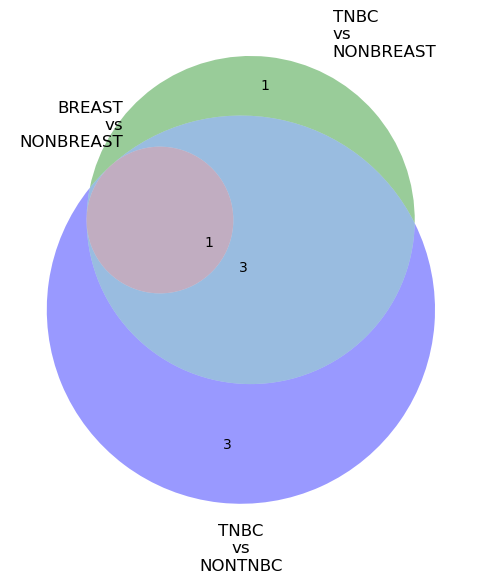

In [190]:
_p = 0.95

f,axes = plt.subplots(1,1, figsize=(6,6))

BREASTvsNONBREAST_set = ['::'.join(x.astype(str)) for x in breast_vs_nonbreast_res[lambda x: x.p_sens > _p][['cmap_name']].drop_duplicates().values]
TNBCvsNONBREAST_set = ['::'.join(x.astype(str)) for x in tnbc_vs_nonbreast_res[lambda x: x.p_sens > _p][['cmap_name']].drop_duplicates().values]
TNBCvsNONTNBC_set = ['::'.join(x.astype(str)) for x in tnbc_vs_nontnbc_res[lambda x: x.p_sens > _p][['cmap_name']].drop_duplicates().values]

v1 = venn3([set(BREASTvsNONBREAST_set), 
       set(TNBCvsNONBREAST_set), 
       set(TNBCvsNONTNBC_set)], ('BREAST\nvs\nNONBREAST', 'TNBC\nvs\nNONBREAST', 'TNBC\nvs\nNONTNBC'), ax=axes)

plt.tight_layout()
plt.show()

# TOP BREAST single agent drugs 

In [191]:
# Identify the top single agents and save to disk

P = 0.75 # `p_sens` threshold for selection of combination screens 

tnbc_vs_nonbreast_topK_drugs = tnbc_vs_nonbreast_res[lambda x: x.p_sens > P].pert_id_1.tolist()
tnbc_vs_nontnbc_topK_drugs = tnbc_vs_nontnbc_res[lambda x: x.p_sens > P].pert_id_1.tolist()
breast_vs_nonbreast_topK_drugs = breast_vs_nonbreast_res[lambda x: x.p_sens > P].pert_id_1.tolist()

tnbc_drugs = np.unique(tnbc_vs_nonbreast_topK_drugs + tnbc_vs_nontnbc_topK_drugs + breast_vs_nonbreast_topK_drugs).tolist()
print('# breast/tnbc drugs:', len(tnbc_drugs))

with open('../output/TNBC_combo_drugs_to_test.txt', 'w') as f: 
    f.write(','.join(tnbc_drugs))

# breast/tnbc drugs: 57


# TNBC combination agent priortization 

1. Select the top N drugs from single agents to use for drug comb. screening 
2. save to disk 
3. run combo priortization 

```bash
(gsnn) $ python prioritize.py --proc ../output/exp1/proc/ --uid_dir ../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/ --goals_path ../output/breast_subtype_goals.csv --model model-100.pt --drugs_path ../output/TNBC_combo_drugs_to_test.txt --doses 0.01 0.1 --verbose --combo
```

## TNBC vs NONBREAST (COMBO)

In [192]:
tnbc_vs_nonbreast_combo_res, counts_res, target_reg_res, target_int_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/breast_subtype_goals_combo/TNBC_vs_nonbreast.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/',
                                                                 save_suffix='__COMBO',
                                                                 run_interaction_regression=True)

tnbc_vs_nonbreast_combo_res.head()

# of overlapping drug indications: 16
# of overlapping drug indications: 16
# of drugs selected: 789
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 0 features/targets
# of obs to drop (due to no targets): 2
thresholding y (0.75) and fitting logistic regression
R2 score: 0.4115
variance filter removed 3 features/targets [interaction regression]
fitting Ridge Logistic regression...


,cmap_name_x,cmap_name_y,p_sens,diff_mean,target_x,target_y,ATC_code_x,ATC_code_y,pert_id_1,dose_um_1,...,diff_var,clinical_phase_x,clinical_phase_y,indication_x,indication_y,disease_area_x,disease_area_y,ATC_code,cmap_name,target
0,roscovitine,alvocidib,1.000,-0.317435,"[CDK2, CDK7, CDK9]","[CDK1, CDK2, CDK4, CDK5, CDK6, CDK7, CDK8, CDK...",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K07691486,0.01,...,0.009222,Phase 2,Phase 2,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,alvocidib |+| roscovitine,"[CDK1, CDK2, CDK4, CDK5, CDK6, CDK7, CDK8, CDK..."
1,MG-132,BMS-265246,1.000,-0.306129,[PSMB1],"[CDK1, CDK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K60230970,0.10,...,0.011280,Preclinical,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,BMS-265246 |+| MG-132,"[CDK1, CDK2, PSMB1]"
2,BMS-265246,ixazomib,0.999,-0.291574,"[CDK1, CDK2]",[PSMB1],UNANNOTATED ATC,"Proteasome inhibitors, antineoplastic agent",BRD-K62814476,0.10,...,0.011651,Preclinical,Launched,NaN,multiple myeloma,NaN,hematologic malignancy,"Proteasome inhibitors, antineoplastic agent |+...",BMS-265246 |+| ixazomib,"[CDK1, CDK2, PSMB1]"
3,mepacrine,BMS-265246,0.998,-0.285846,[TP53],"[CDK1, CDK2]",Other agents against amoebiasis and other prot...,UNANNOTATED ATC,BRD-A45889380,0.10,...,0.009969,Launched,Preclinical,giardiasis,NaN,infectious disease,NaN,Other agents against amoebiasis and other prot...,BMS-265246 |+| mepacrine,"[CDK1, CDK2, TP53]"
4,BMS-265246,BMS-265246,0.998,-0.234830,"[CDK1, CDK2]","[CDK1, CDK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K62814476,0.01,...,0.008519,Preclinical,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,BMS-265246 |+| BMS-265246,"[CDK1, CDK2]"


In [193]:
target_int_res.head(10)

,target,weight,pvalue
0,CDK1,1.418593,0.0
48,merged_CDK8_PYGM*merged_HDAC8_HDAC3_HDAC6_HDAC...,1.258839,0.0
44,PSMB1*ESR1,1.448123,0.0
43,PSMB1*merged_CDK8_PYGM,1.124878,0.0
30,CDK5*merged_CDK8_PYGM,1.232491,0.0
29,CDK5*PSMB1,1.340817,0.0
26,HSP90AA1*merged_HDAC8_HDAC3_HDAC6_HDAC1_HDAC2,1.368959,0.0
22,HSP90AA1*PSMB1,1.294393,0.0
20,HSP90AA1*PPARG,1.429085,0.0
16,CDK1*ESR1,1.229711,0.0


In [194]:
counts_res.head()

,ATC_code,counts,pvalue
0,"Proteasome inhibitors, antineoplastic agent |+...",70,0.000
1,BCR-ABL tyrosine kinase inhibitors |+| UNANNOT...,29,0.002
2,Human epidermal growth factor receptor 2 (HER2...,23,0.168
3,"Anti-estrogens |+| Proteasome inhibitors, anti...",2,0.212
4,"Proteasome inhibitors, antineoplastic agent |+...",3,0.220


In [195]:
target_reg_res.head()

,target,pvalue,weight,N_pos_obs
2,CDK1,3.914075e-16,2.209578,437.0
6,HSP90AA1,1.414884e-14,1.650148,407.0
3,CDK5,6.255359e-13,-2.212971,332.0
14,PPARG,7.935474e-10,-1.947795,173.0
8,MAP2K1,2.319564e-09,-3.391975,116.0


## TNBC vs NONTNBC (COMBO)

In [196]:
tnbc_vs_nontnbc_combo_res, counts_res, target_reg_res, target_int_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/breast_subtype_goals_combo/TNBC_vs_nonTNBC.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/',
                                                                 save_suffix='__COMBO',
                                                                 run_interaction_regression=True)

tnbc_vs_nontnbc_combo_res.head()

# of overlapping drug indications: 16
# of overlapping drug indications: 16
# of drugs selected: 775
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 0 features/targets
# of obs to drop (due to no targets): 2
thresholding y (0.75) and fitting logistic regression
R2 score: 0.3567
variance filter removed 10 features/targets [interaction regression]
fitting Ridge Logistic regression...


,cmap_name_x,cmap_name_y,p_sens,diff_mean,target_x,target_y,ATC_code_x,ATC_code_y,pert_id_1,dose_um_1,...,diff_var,clinical_phase_x,clinical_phase_y,indication_x,indication_y,disease_area_x,disease_area_y,ATC_code,cmap_name,target
0,mepacrine,bortezomib,1.000,-0.420273,[TP53],"[PSMB1, PSMB2, PSMB5]",Other agents against amoebiasis and other prot...,"Proteasome inhibitors, antineoplastic agent",BRD-A45889380,0.01,...,0.016870,Launched,Launched,giardiasis,multiple myeloma|mantle cell lymphoma (MCL),infectious disease,hematologic malignancy,Other agents against amoebiasis and other prot...,bortezomib |+| mepacrine,"[PSMB1, PSMB2, PSMB5, TP53]"
1,roscovitine,alvocidib,0.999,-0.340435,"[CDK2, CDK7, CDK9]","[CDK1, CDK2, CDK4, CDK5, CDK6, CDK7, CDK8, CDK...",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K07691486,0.01,...,0.013629,Phase 2,Phase 2,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,alvocidib |+| roscovitine,"[CDK1, CDK2, CDK4, CDK5, CDK6, CDK7, CDK8, CDK..."
2,MG-132,BMS-265246,0.999,-0.402662,[PSMB1],"[CDK1, CDK2]",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K60230970,0.10,...,0.018237,Preclinical,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,BMS-265246 |+| MG-132,"[CDK1, CDK2, PSMB1]"
3,bortezomib,bortezomib,0.999,-0.431916,"[PSMB1, PSMB2, PSMB5]","[PSMB1, PSMB2, PSMB5]","Proteasome inhibitors, antineoplastic agent","Proteasome inhibitors, antineoplastic agent",BRD-K88510285,0.10,...,0.015649,Launched,Launched,multiple myeloma|mantle cell lymphoma (MCL),multiple myeloma|mantle cell lymphoma (MCL),hematologic malignancy,hematologic malignancy,"Proteasome inhibitors, antineoplastic agent |+...",bortezomib |+| bortezomib,"[PSMB1, PSMB2, PSMB5]"
4,MG-132,alvocidib,0.999,-0.375600,[PSMB1],"[CDK1, CDK2, CDK4, CDK5, CDK6, CDK7, CDK8, CDK...",UNANNOTATED ATC,UNANNOTATED ATC,BRD-K60230970,0.10,...,0.016414,Preclinical,Phase 2,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,MG-132 |+| alvocidib,"[CDK1, CDK2, CDK4, CDK5, CDK6, CDK7, CDK8, CDK..."


In [197]:
target_int_res.head()

,target,weight,pvalue
22,PSMB1*CDK1,1.292036,0.0
1,PSMB1,1.423407,0.0
41,CDK1*merged_CDK8_PYGM,0.649401,0.0
37,HSP90AB1*PPARG,1.462698,0.0
4,HSP90AB1,1.410551,0.0


In [198]:
counts_res.head()

,ATC_code,counts,pvalue
0,"Proteasome inhibitors, antineoplastic agent |+...",67,0.000
1,BCR-ABL tyrosine kinase inhibitors |+| UNANNOT...,30,0.000
2,Other protein kinase inhibitors in ATC |+| UNA...,25,0.044
3,Histone deacetylase (HDAC) inhibitors |+| UNAN...,44,0.080
4,"Proteasome inhibitors, antineoplastic agent |+...",2,0.198


In [199]:
target_reg_res.head()

,target,pvalue,weight,N_pos_obs
4,ESR1,2.346309e-23,-2.674114,286.0
15,PSMB1,1.071826e-10,2.040821,186.0
26,merged_ERBB4_ERBB2_EGFR,2.610714e-10,-1.680816,257.0
11,MDM2,3.940711e-08,-2.392782,59.0
7,HSP90AB1,4.422532e-08,2.159523,68.0


## BREAST vs NONBREAST (COMBO)

In [200]:
breast_vs_nonbreast_combo_res, counts_res, target_reg_res, target_int_res = load_process_save(path       = '../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/prioritizations/breast_subtype_goals_combo/breast_vs_nonbreast.csv', 
                                                                 druginfo   = druginfo, 
                                                                 targinfo   = targinfo, 
                                                                 out_dir    = '/mnt/c/Users/natha/Documents/',
                                                                 save_suffix='__COMBO',
                                                                 run_interaction_regression=True)

breast_vs_nonbreast_combo_res.head()

# of overlapping drug indications: 16
# of overlapping drug indications: 16
# of drugs selected: 893
using method: CORR; merging co-linear features
largest component size: 2
variance filter removed 0 features/targets
# of obs to drop (due to no targets): 2
thresholding y (0.75) and fitting logistic regression
R2 score: 0.4085
variance filter removed 1 features/targets [interaction regression]
fitting Ridge Logistic regression...


,cmap_name_x,cmap_name_y,p_sens,diff_mean,target_x,target_y,ATC_code_x,ATC_code_y,pert_id_1,dose_um_1,...,diff_var,clinical_phase_x,clinical_phase_y,indication_x,indication_y,disease_area_x,disease_area_y,ATC_code,cmap_name,target
0,tanespimycin,torin-2,1.0,-0.274221,[HSP90AA1],[MTOR],UNANNOTATED ATC,UNANNOTATED ATC,BRD-A61304759,0.01,...,0.006857,Phase 3,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,tanespimycin |+| torin-2,"[HSP90AA1, MTOR]"
1,PF-05212384,dasatinib,1.0,-0.214226,"[MTOR, PIK3CA]","[ABL1, BCR, EPHA2, FYN, KIT, LCK, LYN, PDGFRB,...",UNANNOTATED ATC,BCR-ABL tyrosine kinase inhibitors,BRD-K07955840,0.10,...,0.003845,Phase 2,Launched,NaN,chronic myeloid leukemia (CML)|acute lymphobla...,NaN,hematologic malignancy,BCR-ABL tyrosine kinase inhibitors |+| UNANNOT...,PF-05212384 |+| dasatinib,"[ABL1, BCR, EPHA2, FYN, KIT, LCK, LYN, MTOR, P..."
2,PKI-179,dasatinib,1.0,-0.164933,[MTOR],"[ABL1, BCR, EPHA2, FYN, KIT, LCK, LYN, PDGFRB,...",UNANNOTATED ATC,BCR-ABL tyrosine kinase inhibitors,BRD-A28467416,0.10,...,0.003499,Phase 1,Launched,NaN,chronic myeloid leukemia (CML)|acute lymphobla...,NaN,hematologic malignancy,BCR-ABL tyrosine kinase inhibitors |+| UNANNOT...,PKI-179 |+| dasatinib,"[ABL1, BCR, EPHA2, FYN, KIT, LCK, LYN, MTOR, P..."
3,PU-H71,torin-2,1.0,-0.293031,[HSP90AA1],[MTOR],UNANNOTATED ATC,UNANNOTATED ATC,BRD-K36529613,0.10,...,0.006814,Phase 1,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,PU-H71 |+| torin-2,"[HSP90AA1, MTOR]"
4,geldanamycin,torin-2,1.0,-0.241272,[HSP90AA1],[MTOR],UNANNOTATED ATC,UNANNOTATED ATC,BRD-K11528507,0.01,...,0.007903,Preclinical,Preclinical,NaN,NaN,NaN,NaN,UNANNOTATED ATC |+| UNANNOTATED ATC,geldanamycin |+| torin-2,"[HSP90AA1, MTOR]"


In [201]:
target_int_res.head()

,target,weight,pvalue
26,HSP90AA1*MAPK8,1.457491,0.0
49,ESR1*MTOR,1.287434,0.0
48,ESR1*CDK1,1.287769,0.0
47,MAP2K1*MTOR,1.448804,0.0
41,CDK5*ESR1,1.344020,0.0


In [202]:
counts_res.head(10)

,ATC_code,counts,pvalue
0,Selective estrogen receptor modulators |+| UNA...,36,0.000
1,Antigonadotropins and similar agents |+| UNANN...,32,0.000
2,Anti-estrogens |+| UNANNOTATED ATC,38,0.000
3,Human epidermal growth factor receptor 2 (HER2...,29,0.020
4,"Proteasome inhibitors, antineoplastic agent |+...",54,0.050
5,"Proteasome inhibitors, antineoplastic agent |+...",4,0.136
6,"Thiazolidinediones, blood glucose lowering dru...",3,0.154
7,Epidermal growth factor receptor (EGFR) tyrosi...,31,0.166
8,"NO DRUG |+| Thiazolidinediones, blood glucose ...",2,0.296
9,Antigonadotropins and similar agents |+| Prote...,2,0.310


In [203]:
target_reg_res.head()

,target,pvalue,weight,N_pos_obs
28,merged_HDAC8_HDAC3_HDAC6_HDAC1_HDAC2,6.067319e-16,-2.464962,171.0
6,HSP90AA1,4.426017e-14,1.739840,407.0
27,merged_NTRK1_FLT3,4.664959e-14,-2.910002,132.0
14,PPARG,2.293490e-12,-2.040946,173.0
3,CDK5,1.680535e-10,-1.842531,332.0


## BREAST goals overlapping prioritizations

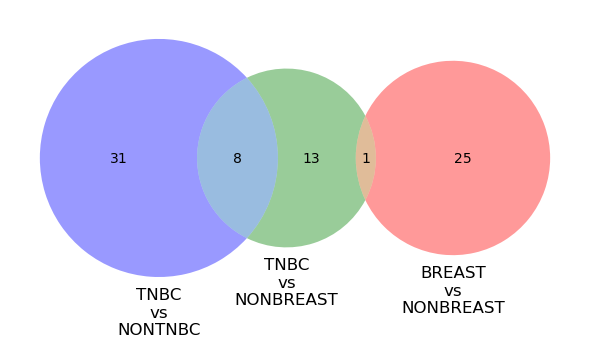

In [204]:
_p = 0.99

f,axes = plt.subplots(1,1, figsize=(6,6))

#plt.title(f'TOP {N} comb-candidates')

BREASTvsNONBREAST_set = ['::'.join(x.astype(str)) for x in breast_vs_nonbreast_combo_res[lambda x: x.p_sens > _p][['cmap_name_x', 'cmap_name_y']].drop_duplicates().values]
TNBCvsNONBREAST_set = ['::'.join(x.astype(str)) for x in tnbc_vs_nonbreast_combo_res[lambda x: x.p_sens > _p][['cmap_name_x', 'cmap_name_y']].drop_duplicates().values]
TNBCvsNONTNBC_set = ['::'.join(x.astype(str)) for x in tnbc_vs_nontnbc_combo_res[lambda x: x.p_sens > _p][['cmap_name_x', 'cmap_name_y']].drop_duplicates().values]

v1 = venn3([set(BREASTvsNONBREAST_set), 
       set(TNBCvsNONBREAST_set), 
       set(TNBCvsNONTNBC_set)], ('BREAST\nvs\nNONBREAST', 'TNBC\nvs\nNONBREAST', 'TNBC\nvs\nNONTNBC'), ax=axes)

'''
legend_elements = [Patch(facecolor=v1.get_patch_by_id('100').get_facecolor(), edgecolor='k', label='Exp1'), 
                   Patch(facecolor=v1.get_patch_by_id('010').get_facecolor(), edgecolor='k', label='Exp2'),
                   Patch(facecolor=v1.get_patch_by_id('001').get_facecolor(), edgecolor='k', label='Exp3'),
                   Patch(facecolor=v1.get_patch_by_id('110').get_facecolor(), edgecolor='k', label='Exp1 + Exp2'),
                   Patch(facecolor=v1.get_patch_by_id('011').get_facecolor(), edgecolor='k', label='Exp2 + Exp3'),
                   Patch(facecolor=v1.get_patch_by_id('101').get_facecolor(), edgecolor='k', label='Exp1 + Exp3'), 
                   Patch(facecolor=v1.get_patch_by_id('111').get_facecolor(), edgecolor='k', label='Exp1 + Exp2 + Exp3'),]
''' 

#f.legend(handles=legend_elements, ncol=7, fontsize=14, loc=( 0, 0))

plt.tight_layout()
plt.show()